## Import

In [1]:
import os
import numpy as np
import pandas as pd
import random
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,GroupKFold
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

## Load

In [2]:
data_dir ="input"
train = pd.read_csv(os.path.join(data_dir,"train.csv"))
test=pd.read_csv(os.path.join(data_dir,"test.csv"))
sub =pd.read_csv(os.path.join(data_dir,"sample_submit.csv"), header=None)
info = pd.read_csv(os.path.join(data_dir,"info.csv"))
network = pd.read_csv(os.path.join(data_dir,"network.csv"))

## Test Ratios

In [3]:
test_ratios=list(test.groupby(["date", "trainNo"])["target"].transform("mean"))
test_ratios=[i for i in test_ratios if i!=0]

## Fix Seed

In [4]:
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

SEED = 2021
fix_seed(SEED)

## Mask Delay Time

In [5]:
results = []
train["target"]=0
train["maskdelayTime"]=train["delayTime"]
for c,g in train.groupby(["date","directionCode","trainNo","lineName"]):
    p=random.choice(test_ratios)
    p=1-p
    g_shape=g.shape[0]
    mask=[0]*int(g_shape*p)+[1]*(g_shape-int(g_shape*p))
    g["target"]=mask
    g.loc[g['target']==1, 'maskdelayTime']=None
    results.append(g)
train=pd.concat(results)

In [6]:
results = []
test["maskdelayTime"]=test["delayTime"]
test["val_target"]=0
for c,g in test.groupby(["date","directionCode","trainNo","lineName"]):
    if g["delayTime"].isnull().sum()!=0:
        results.append(g)
        continue
    p=random.choice(test_ratios)
    p=1-p
    g_shape=g.shape[0]
    mask=[0]*int(g_shape*p)+[1]*(g_shape-int(g_shape*p))
    g["val_target"]=mask
    g.loc[g['val_target']==1, 'maskdelayTime']=None
    results.append(g)
test=pd.concat(results)

In [7]:
test=test.sort_values(by=["id"], ascending=True)

In [8]:
train.head()

,id,date,lineName,directionCode,trainNo,stopStation,planArrival,delayTime,target,maskdelayTime
8202,8202,20191204,B,1,AAJSMo,FPFv,17:22,0.0,0,0.0
8203,8203,20191204,B,1,AAJSMo,mjPK,17:25,0.0,0,0.0
8204,8204,20191204,B,1,AAJSMo,uQdT,17:27,0.0,0,0.0
8205,8205,20191204,B,1,AAJSMo,zNdV,17:29,0.0,0,0.0
8206,8206,20191204,B,1,AAJSMo,KReX,17:31,0.0,0,0.0


In [9]:
test.head()

,id,date,lineName,directionCode,trainNo,stopStation,planArrival,delayTime,target,maskdelayTime,val_target
0,1488885,20191201,A,1,AqTAbk,Rlfq,17:32,0.0,0,0.0,0
1,1488886,20191201,A,1,AqTAbk,coZB,17:34,0.0,0,0.0,0
2,1488887,20191201,A,1,AqTAbk,LMww,17:37,0.0,0,NaN,1
3,1488888,20191201,A,1,AqTAbk,VNyR,17:39,0.0,0,NaN,1
4,1488889,20191201,A,1,AqTAbk,jhlV,17:41,0.0,0,NaN,1


## Feature Engineering

In [10]:
train["year"]=train["date"].map(lambda x:int(str(x)[:4]))
train["month"]=train["date"].map(lambda x:int(str(x)[4:6]))
train["day"]=train["date"].map(lambda x:int(str(x)[6:]))
train["one_hour"]=train["planArrival"].map(lambda x:int(str(x)[:2]))
train["two_hour"]=train["planArrival"].map(lambda x:int(str(x)[:2])//2)

train["group_id"]=train.groupby(["date","directionCode","trainNo","lineName"]).grouper.group_info[0]
train["cumsum"]=train.groupby(["date","directionCode","trainNo","lineName"])["target"].transform(pd.Series.cumsum)
train["delaytime_ffill"]=train.groupby(["date", "trainNo"])["maskdelayTime"].transform(lambda x: x.fillna(method="ffill"))

train["delay_mean_1"]=train.groupby(["date","one_hour","directionCode","trainNo","lineName"])["maskdelayTime"].transform('mean')
train["delay_mean_2"]=train.groupby(["date","two_hour","directionCode","trainNo","lineName"])["maskdelayTime"].transform('mean')
train["delay_mean_3"]=train.groupby(["date","one_hour","directionCode","lineName"])["maskdelayTime"].transform('mean')
train["delay_mean_4"]=train.groupby(["date","two_hour","directionCode","lineName"])["maskdelayTime"].transform('mean')
train["delay_mean_9"]=train.groupby(["date","one_hour","lineName"])["maskdelayTime"].transform('mean')
train["delay_mean_10"]=train.groupby(["date","two_hour","lineName"])["maskdelayTime"].transform('mean')

train["delay_median_1"]=train.groupby(["date","one_hour","directionCode","trainNo","lineName"])["maskdelayTime"].transform('median')
train["delay_median_2"]=train.groupby(["date","two_hour","directionCode","trainNo","lineName"])["maskdelayTime"].transform('median')
train["delay_median_3"]=train.groupby(["date","one_hour","directionCode","lineName"])["maskdelayTime"].transform('median')
train["delay_median_4"]=train.groupby(["date","two_hour","directionCode","lineName"])["maskdelayTime"].transform('median')
train["delay_median_9"]=train.groupby(["date","one_hour","lineName"])["maskdelayTime"].transform('median')
train["delay_median_10"]=train.groupby(["date","two_hour","lineName"])["maskdelayTime"].transform('median')

train["delay_std_1"]=train.groupby(["date","one_hour","directionCode","trainNo","lineName"])["maskdelayTime"].transform('std')
train["delay_std_2"]=train.groupby(["date","two_hour","directionCode","trainNo","lineName"])["maskdelayTime"].transform('std')
train["delay_std_3"]=train.groupby(["date","one_hour","directionCode","lineName"])["maskdelayTime"].transform('std')
train["delay_std_4"]=train.groupby(["date","two_hour","directionCode","lineName"])["maskdelayTime"].transform('std')
train["delay_std_9"]=train.groupby(["date","one_hour","lineName"])["maskdelayTime"].transform('std')
train["delay_std_10"]=train.groupby(["date","two_hour","lineName"])["maskdelayTime"].transform('std')

train["delay_min_1"]=train.groupby(["date","one_hour","directionCode","trainNo","lineName"])["maskdelayTime"].transform('min')
train["delay_min_2"]=train.groupby(["date","two_hour","directionCode","trainNo","lineName"])["maskdelayTime"].transform('min')
train["delay_min_3"]=train.groupby(["date","one_hour","directionCode","lineName"])["maskdelayTime"].transform('min')
train["delay_min_4"]=train.groupby(["date","two_hour","directionCode","lineName"])["maskdelayTime"].transform('min')
train["delay_min_9"]=train.groupby(["date","one_hour","lineName"])["maskdelayTime"].transform('min')
train["delay_min_10"]=train.groupby(["date","two_hour","lineName"])["maskdelayTime"].transform('min')

train["delay_max_1"]=train.groupby(["date","one_hour","directionCode","trainNo","lineName"])["maskdelayTime"].transform('max')
train["delay_max_2"]=train.groupby(["date","two_hour","directionCode","trainNo","lineName"])["maskdelayTime"].transform('max')
train["delay_max_3"]=train.groupby(["date","one_hour","directionCode","lineName"])["maskdelayTime"].transform('max')
train["delay_max_4"]=train.groupby(["date","two_hour","directionCode","lineName"])["maskdelayTime"].transform('max')
train["delay_max_9"]=train.groupby(["date","one_hour","lineName"])["maskdelayTime"].transform('max')
train["delay_max_10"]=train.groupby(["date","two_hour","lineName"])["maskdelayTime"].transform('max')

for i in range(1,20):
    train['delayTime_lag{}'.format(i)] = train.groupby(["date","directionCode","trainNo","lineName"])["maskdelayTime"].transform(lambda x: x.shift(i))

In [11]:
test["year"]=test["date"].map(lambda x:int(str(x)[:4]))
test["month"]=test["date"].map(lambda x:int(str(x)[4:6]))
test["day"]=test["date"].map(lambda x:int(str(x)[6:]))
test["one_hour"]=test["planArrival"].map(lambda x:int(str(x)[:2]))
test["two_hour"]=test["planArrival"].map(lambda x:int(str(x)[:2])//2)

test["group_id"]=test.groupby(["date","directionCode","trainNo","lineName"]).grouper.group_info[0]+72573
test["cumsum"]=test.groupby(["date","directionCode","trainNo","lineName"])["val_target"].transform(pd.Series.cumsum)
test["delaytime_ffill"]=test.groupby(["date", "trainNo"])["maskdelayTime"].transform(lambda x: x.fillna(method="ffill"))

test["delay_mean_1"]=test.groupby(["date","one_hour","directionCode","trainNo","lineName"])["maskdelayTime"].transform('mean')
test["delay_mean_2"]=test.groupby(["date","two_hour","directionCode","trainNo","lineName"])["maskdelayTime"].transform('mean')
test["delay_mean_3"]=test.groupby(["date","one_hour","directionCode","lineName"])["maskdelayTime"].transform('mean')
test["delay_mean_4"]=test.groupby(["date","two_hour","directionCode","lineName"])["maskdelayTime"].transform('mean')
test["delay_mean_9"]=test.groupby(["date","one_hour","lineName"])["maskdelayTime"].transform('mean')
test["delay_mean_10"]=test.groupby(["date","two_hour","lineName"])["maskdelayTime"].transform('mean')

test["delay_median_1"]=test.groupby(["date","one_hour","directionCode","trainNo","lineName"])["maskdelayTime"].transform('median')
test["delay_median_2"]=test.groupby(["date","two_hour","directionCode","trainNo","lineName"])["maskdelayTime"].transform('median')
test["delay_median_3"]=test.groupby(["date","one_hour","directionCode","lineName"])["maskdelayTime"].transform('median')
test["delay_median_4"]=test.groupby(["date","two_hour","directionCode","lineName"])["maskdelayTime"].transform('median')
test["delay_median_9"]=test.groupby(["date","one_hour","lineName"])["maskdelayTime"].transform('median')
test["delay_median_10"]=test.groupby(["date","two_hour","lineName"])["maskdelayTime"].transform('median')

test["delay_std_1"]=test.groupby(["date","one_hour","directionCode","trainNo","lineName"])["maskdelayTime"].transform('std')
test["delay_std_2"]=test.groupby(["date","two_hour","directionCode","trainNo","lineName"])["maskdelayTime"].transform('std')
test["delay_std_3"]=test.groupby(["date","one_hour","directionCode","lineName"])["maskdelayTime"].transform('std')
test["delay_std_4"]=test.groupby(["date","two_hour","directionCode","lineName"])["maskdelayTime"].transform('std')
test["delay_std_9"]=test.groupby(["date","one_hour","lineName"])["maskdelayTime"].transform('std')
test["delay_std_10"]=test.groupby(["date","two_hour","lineName"])["maskdelayTime"].transform('std')

test["delay_min_1"]=test.groupby(["date","one_hour","directionCode","trainNo","lineName"])["maskdelayTime"].transform('min')
test["delay_min_2"]=test.groupby(["date","two_hour","directionCode","trainNo","lineName"])["maskdelayTime"].transform('min')
test["delay_min_3"]=test.groupby(["date","one_hour","directionCode","lineName"])["maskdelayTime"].transform('min')
test["delay_min_4"]=test.groupby(["date","two_hour","directionCode","lineName"])["maskdelayTime"].transform('min')
test["delay_min_9"]=test.groupby(["date","one_hour","lineName"])["maskdelayTime"].transform('min')
test["delay_min_10"]=test.groupby(["date","two_hour","lineName"])["maskdelayTime"].transform('min')

test["delay_max_1"]=test.groupby(["date","one_hour","directionCode","trainNo","lineName"])["maskdelayTime"].transform('max')
test["delay_max_2"]=test.groupby(["date","two_hour","directionCode","trainNo","lineName"])["maskdelayTime"].transform('max')
test["delay_max_3"]=test.groupby(["date","one_hour","directionCode","lineName"])["maskdelayTime"].transform('max')
test["delay_max_4"]=test.groupby(["date","two_hour","directionCode","lineName"])["maskdelayTime"].transform('max')
test["delay_max_9"]=test.groupby(["date","one_hour","lineName"])["maskdelayTime"].transform('max')
test["delay_max_10"]=test.groupby(["date","two_hour","lineName"])["maskdelayTime"].transform('max')

for i in range(1,20):
    test['delayTime_lag{}'.format(i)] = test.groupby(["date","directionCode","trainNo","lineName"])["maskdelayTime"].transform(lambda x: x.shift(i))

In [12]:
train.head()

,id,date,lineName,directionCode,trainNo,stopStation,planArrival,delayTime,target,maskdelayTime,...,delayTime_lag10,delayTime_lag11,delayTime_lag12,delayTime_lag13,delayTime_lag14,delayTime_lag15,delayTime_lag16,delayTime_lag17,delayTime_lag18,delayTime_lag19
8202,8202,20191204,B,1,AAJSMo,FPFv,17:22,0.0,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8203,8203,20191204,B,1,AAJSMo,mjPK,17:25,0.0,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8204,8204,20191204,B,1,AAJSMo,uQdT,17:27,0.0,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8205,8205,20191204,B,1,AAJSMo,zNdV,17:29,0.0,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8206,8206,20191204,B,1,AAJSMo,KReX,17:31,0.0,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
test.head()

,id,date,lineName,directionCode,trainNo,stopStation,planArrival,delayTime,target,maskdelayTime,...,delayTime_lag10,delayTime_lag11,delayTime_lag12,delayTime_lag13,delayTime_lag14,delayTime_lag15,delayTime_lag16,delayTime_lag17,delayTime_lag18,delayTime_lag19
0,1488885,20191201,A,1,AqTAbk,Rlfq,17:32,0.0,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1488886,20191201,A,1,AqTAbk,coZB,17:34,0.0,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1488887,20191201,A,1,AqTAbk,LMww,17:37,0.0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1488888,20191201,A,1,AqTAbk,VNyR,17:39,0.0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1488889,20191201,A,1,AqTAbk,jhlV,17:41,0.0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Remove Unused Feature

In [14]:
train.drop(["id","trainNo","maskdelayTime", 'planArrival'], axis=1, inplace=True)
test.drop(["trainNo",'planArrival'], axis=1, inplace=True)

In [15]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
qualitative = ['date','lineName',"stopStation"]

In [16]:
print(quantitative)
print(qualitative)

['date', 'directionCode', 'delayTime', 'target', 'year', 'month', 'day', 'one_hour', 'two_hour', 'group_id', 'cumsum', 'delaytime_ffill', 'delay_mean_1', 'delay_mean_2', 'delay_mean_3', 'delay_mean_4', 'delay_mean_9', 'delay_mean_10', 'delay_median_1', 'delay_median_2', 'delay_median_3', 'delay_median_4', 'delay_median_9', 'delay_median_10', 'delay_std_1', 'delay_std_2', 'delay_std_3', 'delay_std_4', 'delay_std_9', 'delay_std_10', 'delay_min_1', 'delay_min_2', 'delay_min_3', 'delay_min_4', 'delay_min_9', 'delay_min_10', 'delay_max_1', 'delay_max_2', 'delay_max_3', 'delay_max_4', 'delay_max_9', 'delay_max_10', 'delayTime_lag1', 'delayTime_lag2', 'delayTime_lag3', 'delayTime_lag4', 'delayTime_lag5', 'delayTime_lag6', 'delayTime_lag7', 'delayTime_lag8', 'delayTime_lag9', 'delayTime_lag10', 'delayTime_lag11', 'delayTime_lag12', 'delayTime_lag13', 'delayTime_lag14', 'delayTime_lag15', 'delayTime_lag16', 'delayTime_lag17', 'delayTime_lag18', 'delayTime_lag19']
['date', 'lineName', 'stopStati

In [17]:
train_=train[train['target']==1]
test_=test[test["val_target"]==1]

In [18]:
groups=list(pd.concat([train_["group_id"],test_["group_id"]]))

## Label Encoding

In [19]:
from sklearn import preprocessing
import category_encoders as ce
Label_Enc_list =qualitative
ce_oe = ce.OrdinalEncoder(cols=Label_Enc_list,handle_unknown='impute')
tmp=list(train.columns)
tmp.remove("group_id")
ce_oe.fit(pd.concat([train[tmp],test[tmp]]))
train_=ce_oe.transform(train_[tmp])
test=ce_oe.transform(test[tmp])
test_=ce_oe.transform(test_[tmp])
features=list(train_.columns)
features.remove("delayTime")
features.remove("target")

In [20]:
print(features)

['date', 'lineName', 'directionCode', 'stopStation', 'year', 'month', 'day', 'one_hour', 'two_hour', 'cumsum', 'delaytime_ffill', 'delay_mean_1', 'delay_mean_2', 'delay_mean_3', 'delay_mean_4', 'delay_mean_9', 'delay_mean_10', 'delay_median_1', 'delay_median_2', 'delay_median_3', 'delay_median_4', 'delay_median_9', 'delay_median_10', 'delay_std_1', 'delay_std_2', 'delay_std_3', 'delay_std_4', 'delay_std_9', 'delay_std_10', 'delay_min_1', 'delay_min_2', 'delay_min_3', 'delay_min_4', 'delay_min_9', 'delay_min_10', 'delay_max_1', 'delay_max_2', 'delay_max_3', 'delay_max_4', 'delay_max_9', 'delay_max_10', 'delayTime_lag1', 'delayTime_lag2', 'delayTime_lag3', 'delayTime_lag4', 'delayTime_lag5', 'delayTime_lag6', 'delayTime_lag7', 'delayTime_lag8', 'delayTime_lag9', 'delayTime_lag10', 'delayTime_lag11', 'delayTime_lag12', 'delayTime_lag13', 'delayTime_lag14', 'delayTime_lag15', 'delayTime_lag16', 'delayTime_lag17', 'delayTime_lag18', 'delayTime_lag19']


## Train Data

In [21]:
X=pd.concat([train_[features],test_[features]]).reset_index(drop=True)
y=pd.concat([train_["delayTime"],test_["delayTime"]]).reset_index(drop=True)

In [22]:
print(features)

['date', 'lineName', 'directionCode', 'stopStation', 'year', 'month', 'day', 'one_hour', 'two_hour', 'cumsum', 'delaytime_ffill', 'delay_mean_1', 'delay_mean_2', 'delay_mean_3', 'delay_mean_4', 'delay_mean_9', 'delay_mean_10', 'delay_median_1', 'delay_median_2', 'delay_median_3', 'delay_median_4', 'delay_median_9', 'delay_median_10', 'delay_std_1', 'delay_std_2', 'delay_std_3', 'delay_std_4', 'delay_std_9', 'delay_std_10', 'delay_min_1', 'delay_min_2', 'delay_min_3', 'delay_min_4', 'delay_min_9', 'delay_min_10', 'delay_max_1', 'delay_max_2', 'delay_max_3', 'delay_max_4', 'delay_max_9', 'delay_max_10', 'delayTime_lag1', 'delayTime_lag2', 'delayTime_lag3', 'delayTime_lag4', 'delayTime_lag5', 'delayTime_lag6', 'delayTime_lag7', 'delayTime_lag8', 'delayTime_lag9', 'delayTime_lag10', 'delayTime_lag11', 'delayTime_lag12', 'delayTime_lag13', 'delayTime_lag14', 'delayTime_lag15', 'delayTime_lag16', 'delayTime_lag17', 'delayTime_lag18', 'delayTime_lag19']


## Train Model (GroupKFold)

In [23]:
folds = GroupKFold(n_splits=10)
sub_preds = np.zeros(test.shape[0])
params = {
    'objective': 'huber',
    'metric': 'huber'}
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X, y, groups=groups)):
    best_params, history = {}, []
    X_train, y_train = X[features].iloc[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X[features].iloc[val_idx], y.iloc[val_idx]
    train_set = lgb.Dataset(X_train, y_train)
    val_set = lgb.Dataset(X_valid, y_valid)
    model = lgb.train(params, train_set,num_boost_round = 5000, early_stopping_rounds = 200, 
                         valid_sets = [train_set, val_set],categorical_feature =Label_Enc_list,  verbose_eval = 100)
    sub_preds += model.predict(test[features]) / folds.n_splits

Training until validation scores don't improve for 200 rounds
[100]	training's huber: 0.51351	valid_1's huber: 0.546582
[200]	training's huber: 0.386026	valid_1's huber: 0.425191
[300]	training's huber: 0.336096	valid_1's huber: 0.374175
[400]	training's huber: 0.305614	valid_1's huber: 0.341746
[500]	training's huber: 0.283383	valid_1's huber: 0.317039
[600]	training's huber: 0.26705	valid_1's huber: 0.299459
[700]	training's huber: 0.254653	valid_1's huber: 0.284886
[800]	training's huber: 0.244779	valid_1's huber: 0.274325
[900]	training's huber: 0.238693	valid_1's huber: 0.268807
[1000]	training's huber: 0.233855	valid_1's huber: 0.265918
[1100]	training's huber: 0.227612	valid_1's huber: 0.26335
[1200]	training's huber: 0.222126	valid_1's huber: 0.261163
[1300]	training's huber: 0.217877	valid_1's huber: 0.259685
[1400]	training's huber: 0.212577	valid_1's huber: 0.258676
[1500]	training's huber: 0.20793	valid_1's huber: 0.257463
[1600]	training's huber: 0.20383	valid_1's huber: 0

[2400]	training's huber: 0.180241	valid_1's huber: 0.307491
[2500]	training's huber: 0.177113	valid_1's huber: 0.306699
[2600]	training's huber: 0.174041	valid_1's huber: 0.30605
[2700]	training's huber: 0.171626	valid_1's huber: 0.305499
[2800]	training's huber: 0.168871	valid_1's huber: 0.304809
[2900]	training's huber: 0.16595	valid_1's huber: 0.304275
[3000]	training's huber: 0.163809	valid_1's huber: 0.303816
[3100]	training's huber: 0.161367	valid_1's huber: 0.303427
[3200]	training's huber: 0.160382	valid_1's huber: 0.302607
[3300]	training's huber: 0.159426	valid_1's huber: 0.30171
[3400]	training's huber: 0.158583	valid_1's huber: 0.300899
[3500]	training's huber: 0.15735	valid_1's huber: 0.300475
[3600]	training's huber: 0.155819	valid_1's huber: 0.300221
[3700]	training's huber: 0.154307	valid_1's huber: 0.29992
[3800]	training's huber: 0.153613	valid_1's huber: 0.299767
[3900]	training's huber: 0.152936	valid_1's huber: 0.29944
[4000]	training's huber: 0.152262	valid_1's hu

[2300]	training's huber: 0.184142	valid_1's huber: 0.269656
Early stopping, best iteration is:
[2192]	training's huber: 0.185648	valid_1's huber: 0.269425
Training until validation scores don't improve for 200 rounds
[100]	training's huber: 0.512217	valid_1's huber: 0.557907
[200]	training's huber: 0.385786	valid_1's huber: 0.429027
[300]	training's huber: 0.334642	valid_1's huber: 0.383621
[400]	training's huber: 0.304223	valid_1's huber: 0.356847
[500]	training's huber: 0.281819	valid_1's huber: 0.340238
[600]	training's huber: 0.264309	valid_1's huber: 0.328459
[700]	training's huber: 0.249906	valid_1's huber: 0.319518
[800]	training's huber: 0.240441	valid_1's huber: 0.314571
[900]	training's huber: 0.233978	valid_1's huber: 0.312228
[1000]	training's huber: 0.226573	valid_1's huber: 0.309238
[1100]	training's huber: 0.221717	valid_1's huber: 0.307375
[1200]	training's huber: 0.216844	valid_1's huber: 0.304975
[1300]	training's huber: 0.212013	valid_1's huber: 0.302834
[1400]	train

## PostProcessing + Submission

In [24]:
sub_ids=[i-1488885 for i in sub.iloc[:,0].values]

In [25]:
sub.iloc[:,1]=np.where(sub_preds[sub_ids]<= 0,0, sub_preds[sub_ids])

In [26]:
sub.to_csv('submission.csv',header=None,index=False)

In [27]:
sub.head()

,0,1
0,1488935,3.612861
1,1488936,3.474753
2,1488937,3.680170
3,1488938,3.669980
4,1488939,3.583173


## Visualize Feature Importance

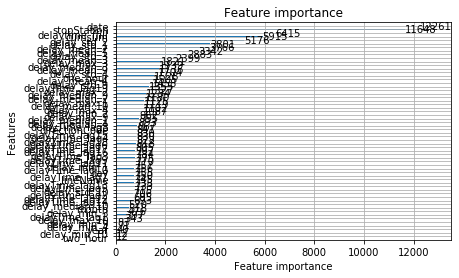

In [28]:
lgb.plot_importance(model)